In [10]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import pandas as pd

## Load Important Function

In [6]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [15]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    # Convert each element in omega to shifted_omega
    shifted_omega = [(arr + 90.0) % 360.0 - 90.0 for arr in omega]
    
    # Convert to cis/trans (0 = cis, 1 = trans) using np.where
    cistrans = [np.where(arr > 90.0, 1, 0).astype(int) for arr in shifted_omega]
    return cistrans


In [8]:
def autocorr(x):
    tau = x.size
    mu = x.mean()
    var = x.var()  # Variance for normalization
    g = np.correlate((x-mu), (x-mu), mode='full')[tau-1:]
    g = g / var
    n = np.arange(tau,0,-1)
    return g/n

In [ ]:
def multi_autocorr(x_list, max_tau=None):
    """Given a list of 1D trajectories x (each could be different lengths), compute an autocorrelation.
    INPUTS
    x_list  - a list of np.array objects. Each could be different lengths .

    PARAMETERS
    max_tau - the maximum frame to compute the autocorrelation.  If None, use the whole range. Default: None.
    """


    from tqdm import tqdm

    ntraj = len(x_list)
    x = np.concatenate(x_list)
    mu = x.mean(axis=0)
    var = x.var(axis=0)

    max_trajlength = max( [ x_list[i].shape[0] for i in range(ntraj) ])
    
    if max_tau == None:
        max_tau = max_trajlength
        
    elif max_tau > max_trajlength:
        print("Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength") 
        max_tau = max_trajlength
        
    result = np.zeros( max_tau )
    n = np.zeros( (max_tau,) )
        
    for i in tqdm(range(ntraj)):

        this_tau = x_list[i].shape[0]
        print(f'Analyzing traj {i} of {ntraj} ({this_tau} frames)...')
        if this_tau > max_tau:
            ### NOTE:   np.correlate(...., mode='full') returns a 2N-1 length cross-correl of all possible shifts
            T = 2*this_tau-1
            result[0:max_tau] += np.correlate((x_list[i] - mu), (x_list[i] - mu), mode='full')[this_tau-1:this_tau-1+max_tau]
            n[0:max_tau] += np.arange(this_tau,0,-1)[0:max_tau]
        else:
            result[0:this_tau] += np.correlate((x_list[i] - mu), (x_list[i] - mu), mode='full')[this_tau-1:]
            n[0:this_tau] += np.arange(this_tau,0,-1)
                
    result = result / var
    return result/n

In [21]:
def multi_autocorr(x_list, max_tau=None):
    """Given a list of 1D trajectories x (each could be different lengths), compute an autocorrelation.
    INPUTS
    x_list  - a list of np.array objects. Each could be different lengths.

    PARAMETERS
    max_tau - the maximum frame to compute the autocorrelation.  If None, use the whole range. Default: None.
    """

    from tqdm import tqdm
    import numpy as np

    ntraj = len(x_list)
    x = np.concatenate(x_list)
    mu = x.mean(axis=0)
    var = x.var(axis=0)

    max_trajlength = max([x_list[i].shape[0] for i in range(ntraj)])
    
    if max_tau is None:
        max_tau = max_trajlength
        
    elif max_tau > max_trajlength:
        print("Error: max_tau must be less or equal to the maximum trajectory length. Setting max_tau = max_trajlength") 
        max_tau = max_trajlength
        
    result = np.zeros(max_tau)
    n = np.zeros((max_tau,))
        
    with tqdm(range(ntraj), desc="Processing trajectories", leave=True) as pbar:
        for i in pbar:
            this_tau = x_list[i].shape[0]
            
            if this_tau > max_tau:
                T = 2 * this_tau - 1
                result[0:max_tau] += np.correlate((x_list[i] - mu), (x_list[i] - mu), mode='full')[this_tau-1:this_tau-1+max_tau]
                n[0:max_tau] += np.arange(this_tau, 0, -1)[0:max_tau]
            else:
                result[0:this_tau] += np.correlate((x_list[i] - mu), (x_list[i] - mu), mode='full')[this_tau-1:]
                n[0:this_tau] += np.arange(this_tau, 0, -1)
                
    result = result / var
    return result / n

## Load the data

In [13]:
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/data.pkl").array_list  # This is an (742, x, 3) array

print(len(all_omega)) 

all_omega[0].shape
all_omega[0]

742


array([[-173.65106  ,    8.187268 ,  158.7122   ],
       [ 149.942    ,   -5.472654 , -179.34113  ],
       [ 162.98587  ,    2.9294653, -170.57141  ],
       ...,
       [ -25.63846  ,    6.4290886, -142.46432  ],
       [  -1.3674331,   47.98817  , -169.6922   ],
       [ -16.094692 ,   27.522018 ,  177.88043  ]], dtype=float32)

In [16]:
# This a list of 742 (N_i, 3) np.arrays, where N_i is the size of the i^{th} trajectory
all_cistrans = omega2cistrans(all_omega)

all_cistrans[0].shape
all_cistrans[0]


array([[1, 0, 1],
       [1, 0, 1],
       [1, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

## Compute average and stddev over the 0=cis/1=trans trajectories 

In [17]:
# This a list of 742 (N_i, 3) np.arrays, where N_i is the size of the i^{th} trajectory
ntraj = len(all_cistrans)

# convert to floats for downstream operations
for i in range(ntraj):
    all_cistrans[i] = all_cistrans[i].astype(float)

# Find the longest traj
maxlength = max( [ len(all_cistrans[i]) for i in range(ntraj) ])
minlength = min( [ len(all_cistrans[i]) for i in range(ntraj) ])
ns_per_step = 0.01
print(f'minlength = {minlength} snapshots ({minlength*ns_per_step:.3f} ns)')
print(f'maxlength = {maxlength} snapshots ({maxlength*ns_per_step:.3f} ns)')

# Make an array to store all the trajectories
arr_cistrans = np.nan * np.ones( (ntraj, maxlength, 3) )

for i in range(ntraj):
    n = len(all_cistrans[i])
    arr_cistrans[i, 0:n, :] = all_cistrans[i]

arr_cistrans.shape

minlength = 3001 snapshots (30.010 ns)
maxlength = 196095 snapshots (1960.950 ns)


(742, 196095, 3)

## Autocoorelation Plot

In [ ]:
ntraj = len(all_cistrans)
all_cistrans_res0 = [ all_cistrans[i][:,0] for i in range(ntraj) ]
all_cistrans_res1 = [ all_cistrans[i][:,1] for i in range(ntraj) ]
all_cistrans_res2 = [ all_cistrans[i][:,2] for i in range(ntraj) ]

max_tau = 100000
stride = 1
result_res0 = multi_autocorr(all_cistrans_res0[0::stride], max_tau=max_tau)
result_res1 = multi_autocorr(all_cistrans_res1[0::stride], max_tau=max_tau)
result_res2 = multi_autocorr(all_cistrans_res2[0::stride], max_tau=max_tau)

Processing trajectories: 100%|██████████| 742/742 [09:48<00:00,  1.26it/s]


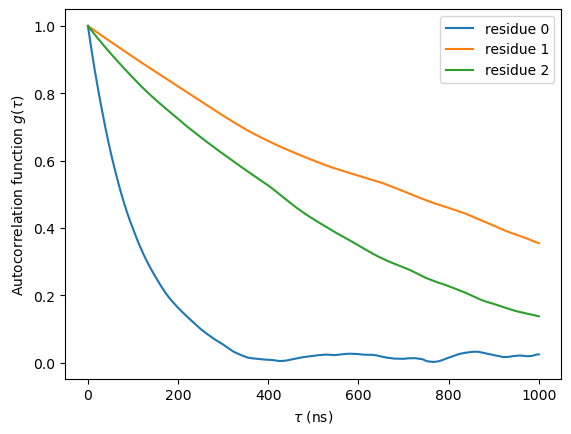

In [25]:
ns_per_step = 0.01
max_tau_res0 = result_res0.shape[0]
max_tau_res1 = result_res1.shape[0]
max_tau_res2 = result_res2.shape[0]

plt.figure()
plt.plot(np.arange(max_tau_res0)*ns_per_step, result_res0, label='residue 0')
plt.plot(np.arange(max_tau_res1)*ns_per_step, result_res1, label='residue 1')
plt.plot(np.arange(max_tau_res2)*ns_per_step, result_res2, label='residue 2')
plt.xlabel(r'$\tau$ (ns)')
plt.ylabel(r'Autocorrelation function $g(\tau)$')
plt.legend(loc='best')

plt.savefig('autocorrel_res012_1us.pdf')